# Comparison Between fPCA and PCA

In [1]:
import os 
import pandas as pd
import numpy as np
from loadData import load_profile, smooth
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from skfda import FDataGrid
from skfda.preprocessing.dim_reduction import FPCA
from skfda.representation.basis import BSplineBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.decomposition import PCA

In [2]:
def load_transcript():
    tss = pd.read_csv(
        'data/ref/GSE49026_S-TSS.txt',
        delimiter='\t',
        usecols=['chr', 'coordinate', 'ORF']
    )
    tss.columns = ['chr', 'start', 'ORF']
    pas = pd.read_csv(
        'data/ref/GSE49026_S-PAS.txt',
        delimiter='\t',
        usecols=['coordinate', 'ORF']
    )
    pas.columns = ['end', 'ORF']
    combined_df = pd.merge(left=tss, right=pas, left_on='ORF', right_on='ORF')
    combined_df['size'] = np.abs(combined_df['start'] - combined_df['end'])
    return combined_df

In [4]:
wt_ocampo_a = load_profile('data/mat/Ocampo_WT_A/')
wt_ocampo_b = load_profile('data/mat/Ocampo_WT_B/')
drop_list = ['cluster', 'ORF']
ocampo_a_fd = FDataGrid(
    data_matrix=wt_ocampo_a.drop(drop_list, axis=1).to_numpy(),
    grid_points=np.arange(wt_ocampo_a.drop(drop_list, axis=1).to_numpy().shape[1]),
)

ocampo_b_fd = FDataGrid(
    data_matrix=wt_ocampo_b.drop(drop_list, axis=1).to_numpy(),
    grid_points=np.arange(wt_ocampo_b.drop(drop_list, axis=1).to_numpy().shape[1]),
)

## Comparison With Other Smoothing Techniques

In [5]:
sm_window_size = 1200 / 20.
sm_window = np.ones(int(sm_window_size)) / sm_window_size
smoothed_data = np.apply_along_axis(
    lambda gene: np.convolve(gene, sm_window, mode='same'), 
    axis=1,
    arr=wt_ocampo_a.drop(drop_list, axis=1).to_numpy()
)

In [6]:
bspline_basis = BSplineBasis(n_basis=20)
bspline_ocampo_a = ocampo_a_fd.to_basis(bspline_basis)

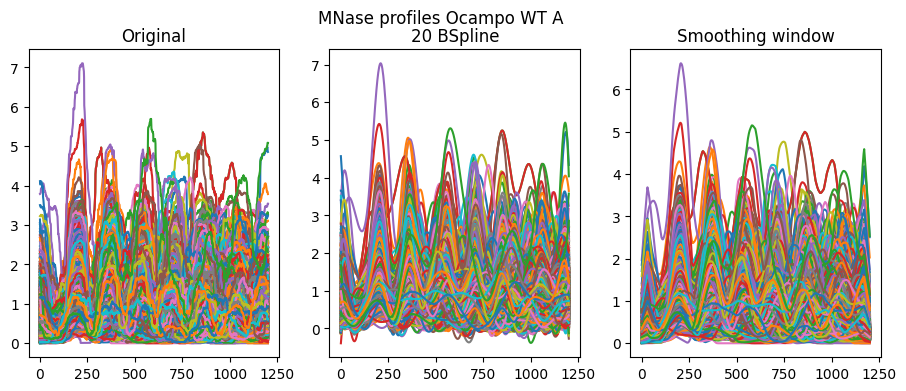

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(11, 4))
ax[0].plot(wt_ocampo_a.drop(drop_list, axis=1).to_numpy().T)
bspline_ocampo_a.plot(chart=ax[1])
ax[2].plot(smoothed_data.T)
fig.suptitle('MNase profiles Ocampo WT A')
ax[0].set_title('Original')
ax[1].set_title('20 BSpline')
ax[2].set_title('Smoothing window')
plt.show()

## Clustering Distribution After Classical PCA

In [8]:
pca_2d = PCA(n_components=2)
coord_2d = pca_2d.fit_transform(wt_ocampo_a.drop(drop_list, axis=1).to_numpy())
pca_3d = PCA(n_components=3)
coord_3d = pca_3d.fit_transform(wt_ocampo_a.drop(drop_list, axis=1).to_numpy())

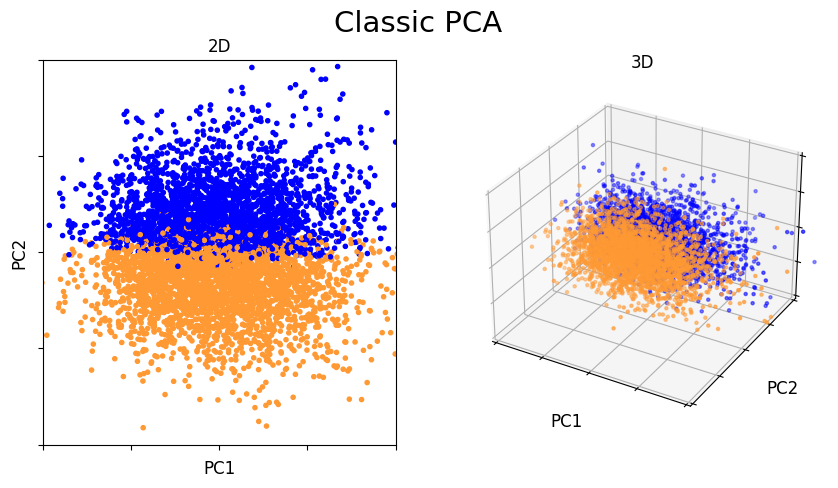

In [10]:
colors = np.array([[0., 0., 1., 1., ], [1., .6, .2, 1., ]])

fig = plt.figure(figsize=(10, 5))
(ax_2d, ax_3d) = fig.add_subplot(121), fig.add_subplot(122, projection='3d')
ax_2d.scatter(*coord_2d.T, color=colors[wt_ocampo_a['cluster'] - 1], marker='.')
ax_3d.scatter(*coord_3d.T, color=colors[wt_ocampo_a['cluster'] - 1], marker='.')
ax_2d.set_title('2D')
ax_3d.set_title('3D')
for a in [ax_2d, ax_3d]:
    a.set_ylim((-20, 20))
    a.set_xlim((-20, 20))
    a.set_xlabel('PC1', fontsize=12)
    a.set_ylabel('PC2', fontsize=12)
    a.set_xticks(np.arange(-20, 21, 10))
    a.set_xticklabels([])
    a.set_yticks(np.arange(-20, 21, 10))
    a.set_yticklabels([])
    
ax_3d.set_zlim((-20, 20))
ax_3d.set_zlabel('PC3', fontsize=12, rotation=90)
ax_3d.set_zticks(np.arange(-20, 21, 10))
ax_3d.set_zticklabels([])
fig.suptitle('Classic PCA', fontsize=21)
plt.show()

In [11]:
fpca_ocampo_a, fpca_ocampo_b = FPCA(n_components=2), FPCA(n_components=2)
fpc_scores_ocampo_a = fpca_ocampo_a.fit_transform(bspline_ocampo_a)

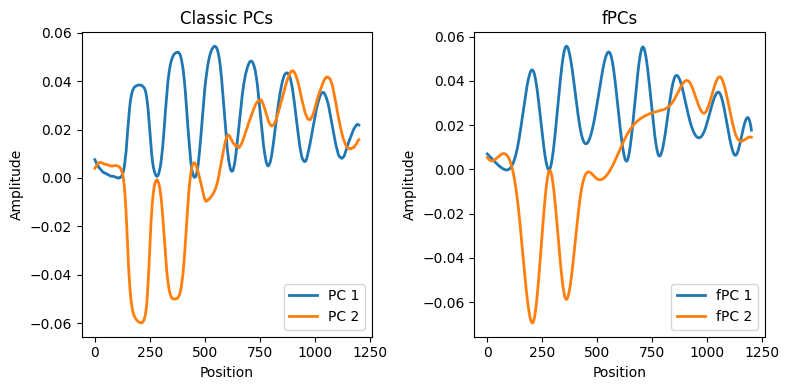

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].plot(pca_2d.components_.T, lw=2)
ax[0].set_xlabel('Position')
ax[0].set_ylabel('Amplitude')
ax[0].set_title('Classic PCs')
ax[0].legend(['PC 1', 'PC 2'])

fpca_ocampo_a.components_.plot(chart=ax[1])
ax[1].get_lines()[0].set_color('tab:blue')
ax[1].get_lines()[0].set_linewidth(2)
ax[1].get_lines()[1].set_color('tab:orange')
ax[1].get_lines()[1].set_linewidth(2)
ax[1].set_xlabel('Position')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('fPCs')
ax[1].legend(['fPC 1', 'fPC 2'])

fig.tight_layout()
plt.show()

In [20]:
pca_2d.explained_variance_ratio_

array([0.20527784, 0.11031161])

In [21]:
pca_3d.explained_variance_ratio_

array([0.20527784, 0.11031161, 0.08783075])

## Use Smoothed Data For fPCA

In [14]:
pca_2d_smoothed = PCA(n_components=2)
coord_2d_smoothed = pca_2d_smoothed.fit_transform(smoothed_data)
pca_3d_smoothed = PCA(n_components=3)
coord_3d_smoothed = pca_3d_smoothed.fit_transform(smoothed_data)

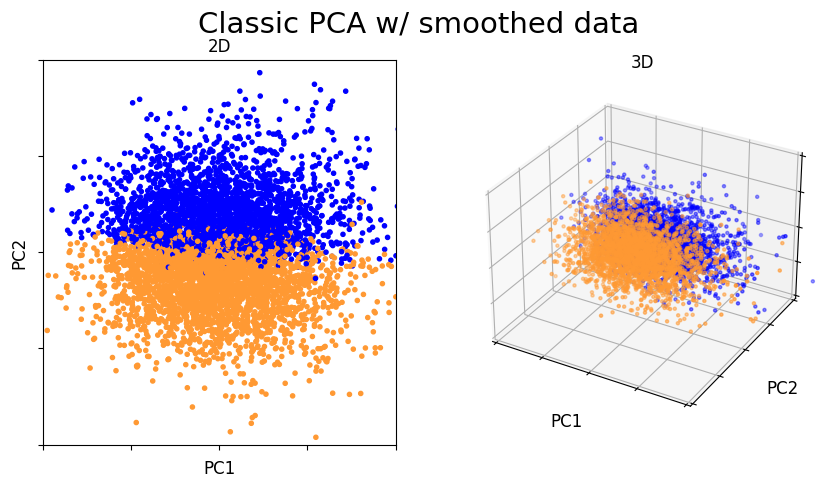

In [17]:
fig = plt.figure(figsize=(10, 5))
(ax_2d, ax_3d) = fig.add_subplot(121), fig.add_subplot(122, projection='3d')
ax_2d.scatter(*coord_2d_smoothed.T, color=colors[wt_ocampo_a['cluster'] - 1], marker='.')
ax_3d.scatter(*coord_3d_smoothed.T, color=colors[wt_ocampo_a['cluster'] - 1], marker='.')
ax_2d.set_title('2D')
ax_3d.set_title('3D')
for a in [ax_2d, ax_3d]:
    a.set_ylim((-20, 20))
    a.set_xlim((-20, 20))
    a.set_xlabel('PC1', fontsize=12)
    a.set_ylabel('PC2', fontsize=12)
    a.set_xticks(np.arange(-20, 21, 10))
    a.set_xticklabels([])
    a.set_yticks(np.arange(-20, 21, 10))
    a.set_yticklabels([])
    
ax_3d.set_zlim((-20, 20))
ax_3d.set_zlabel('PC3', fontsize=12, rotation=90)
ax_3d.set_zticks(np.arange(-20, 21, 10))
ax_3d.set_zticklabels([])
fig.suptitle('Classic PCA w/ smoothed data', fontsize=21)
plt.show()

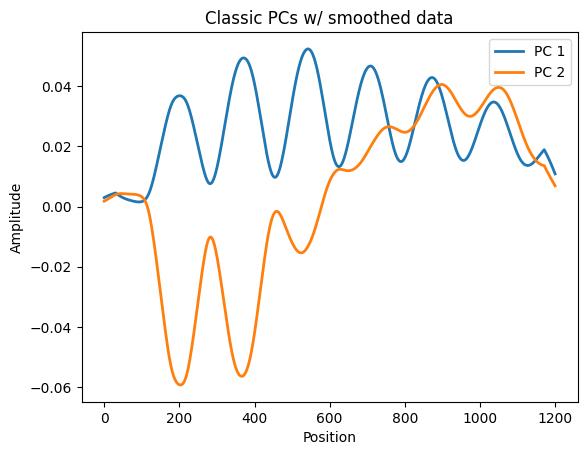

In [19]:
plt.plot(pca_2d_smoothed.components_.T, lw=2)
plt.xlabel('Position')
plt.ylabel('Amplitude')
plt.title('Classic PCs w/ smoothed data')
plt.legend(['PC 1', 'PC 2'])
plt.show()